<a href="https://colab.research.google.com/github/SofyaKirsanova/Log_Analysis/blob/main/Log_Preprossecing_with_text_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Датасет [BGL](https://github.com/logpai/loghub/tree/master/BGL)

По ссылке представлена часть датасета (в нем 2000 строк). На нем и будет тестироваться алгоритм. Полный датасет содержит 4 747 963 строки (из них 348 460 аномалий.

Из описания датасета: 

Это открытый набор данных логов, собранных из суперкомпьютерной системы BlueGene/L в Национальной лаборатории Лоуренса Ливермора (LLNL) в Ливерморе, Калифорния, с 131 072 процессорами и 32 768 ГБ памяти. 

Лог содержит предупреждающие и не предупреждающие сообщения, которые идентифицированы тегами категорий предупреждений. В первом столбце "-" указывает на сообщения, не содержащие предупреждений, в то время как другие являются предупреждающими сообщениями. Эта информация поддается обнаружению предупреждений и прогнозированию. Она использовалась в нескольких исследованиях по анализу логов, обнаружению аномалий и прогнозированию сбоев.

Более подробная информация есть в оригинальной статье:

Adam J. Oliner, Jon Stearley. What Supercomputers Say: A Study of Five System Logs, in Proc. of IEEE/IFIP International Conference on Dependable Systems and Networks (DSN), 2007.

Вид логов в наборе:

```
- 1117842974 2005.06.03 R24-M0-N1-C:J13-U11 2005-06-03-16.56.14.254137 R24-M0-N1-C:J13-U11 RAS KERNEL INFO 162 double-hummer alignment exceptions
- 1117843015 2005.06.03 R21-M1-N6-C:J08-U11 2005-06-03-16.56.55.309974 R21-M1-N6-C:J08-U11 RAS KERNEL INFO 141 double-hummer alignment exceptions
- 1117848119 2005.06.03 R16-M1-N2-C:J17-U01 2005-06-03-18.21.59.871925 R16-M1-N2-C:J17-U01 RAS KERNEL INFO CE sym 2, at 0x0b85eee0, mask 0x05
APPREAD 1117869872 2005.06.04 R04-M1-N4-I:J18-U11 2005-06-04-00.24.32.432192 R04-M1-N4-I:J18-U11 RAS APP FATAL ciod: failed to read message prefix on control stream (CioStream socket to 172.16.96.116:33569
APPREAD 1117869876 2005.06.04 R27-M1-N4-I:J18-U01 2005-06-04-00.24.36.222560 R27-M1-N4-I:J18-U01 RAS APP FATAL ciod: failed to read message prefix on control stream (CioStream socket to 172.16.96.116:33370
- 1117942120 2005.06.04 R30-M0-N7-C:J08-U01 2005-06-04-20.28.40.767551 R30-M0-N7-C:J08-U01 RAS KERNEL INFO CE sym 20, at 0x1438f9e0, mask 0x40
- 1117955341 2005.06.05 R25-M0-N7-C:J02-U01 2005-06-05-00.09.01.903373 R25-M0-N7-C:J02-U01 RAS KERNEL INFO generating core.2275
- 1117955392 2005.06.05 R24-M1-N8-C:J09-U11 2005-06-05-00.09.52.516674 R24-M1-N8-C:J09-U11 RAS KERNEL INFO generating core.862
```
Первые 3 и последние 3 строки не имеют ошибок, а в 4, 5 и 6 строках есть данные об ошибках

Алгоритм предварительной обработки: Template2Vec

Он основан на известном алгоритме Word2Vec, который создает векторы, являющиеся представлениями каких-то функций слов  (например, контекст отдельных слов).

Однако он не улавливает семантическую информацию: синонимы и антонимы. Слова, имеющие похожий или одинаковый контекст в двух шаблонах логов, во многих случаях могут быть антонимами, что делает два шаблона очень
разными. Например, слово “вниз” в шаблоне T1
и слово “вверх” в шаблоне T3 на рисунке, которые являются
антонимами, имеют один и тот же контекст. 

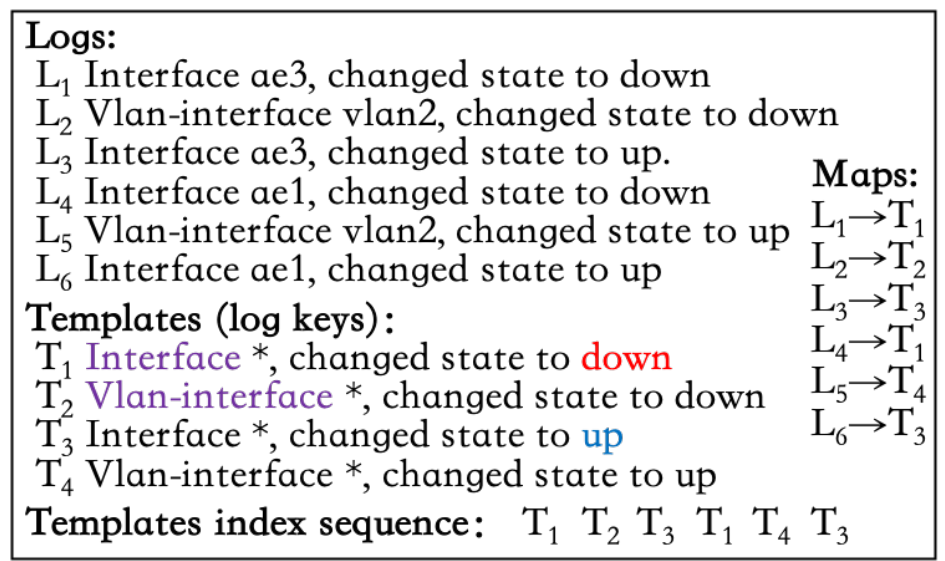



Очевидно, что эти два шаблона имеют противоположное значение, и у них должны быть очень разные векторы. Поэтому необходимо фиксировать
семантическую информацию при построении векторов для представления шаблонов.
В статьяе предлагается новый метод представления слов -- template2Vec, который основан на синонимах и антонимах для эффективного представления слов в распределенных шаблонах.
Template2Vec включает в себя три этапа на этапе
автономного обучения: 

(1) Создание набора синонимов и антонимов. Как показано в таблице 1, универсальные синонимы и антонимы можно найти в лексической базой данных для английского языка [WordNet](https://wordnet.princeton.edu/). Однако некоторые доменные синонимы
и антонимы должны быть добавлены вручную на основе знаний о домене. Поэтому мы сначала ищем синонимы и антонимы слов в шаблонах в WordNet. После этого можно вручную обновлять синонимы и антонимы.
 
("Operators" в таблице означает ввод вручную)
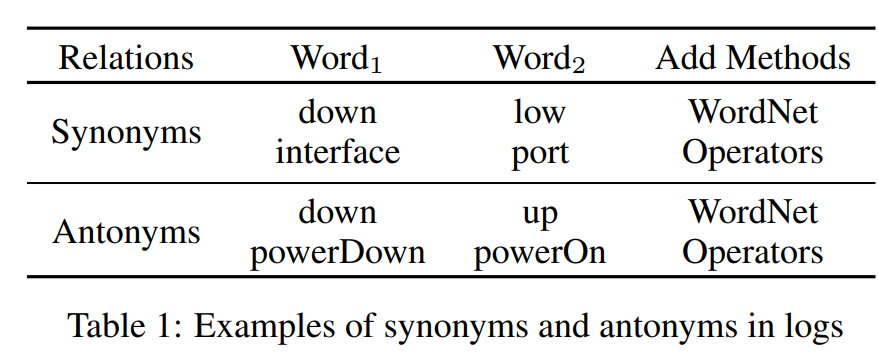

(2) Создание векторов слов. Для этого применяется [dLCE](https://ieeexplore.ieee.org/document/6904105) [Nguyen et al., 2016], которая представляет собой распределенную лексико-контрастную модель встраивания, которая и представляет слова в шаблонах.

(3) Вычисление векторов шаблонов. Для шаблона мы вычисляем его вектор, который является средневзвешенным значением векторов слов слов в шаблоне, чтобы представить распределение шаблона. На этапе обнаружения в реальном времени он сопоставит “временный” вектор шаблона с существующим для новых типов логов. Таким образом, template2Vec объединяет знания о предметной области операторов и модель dLCE для точной генерации векторов шаблонов.

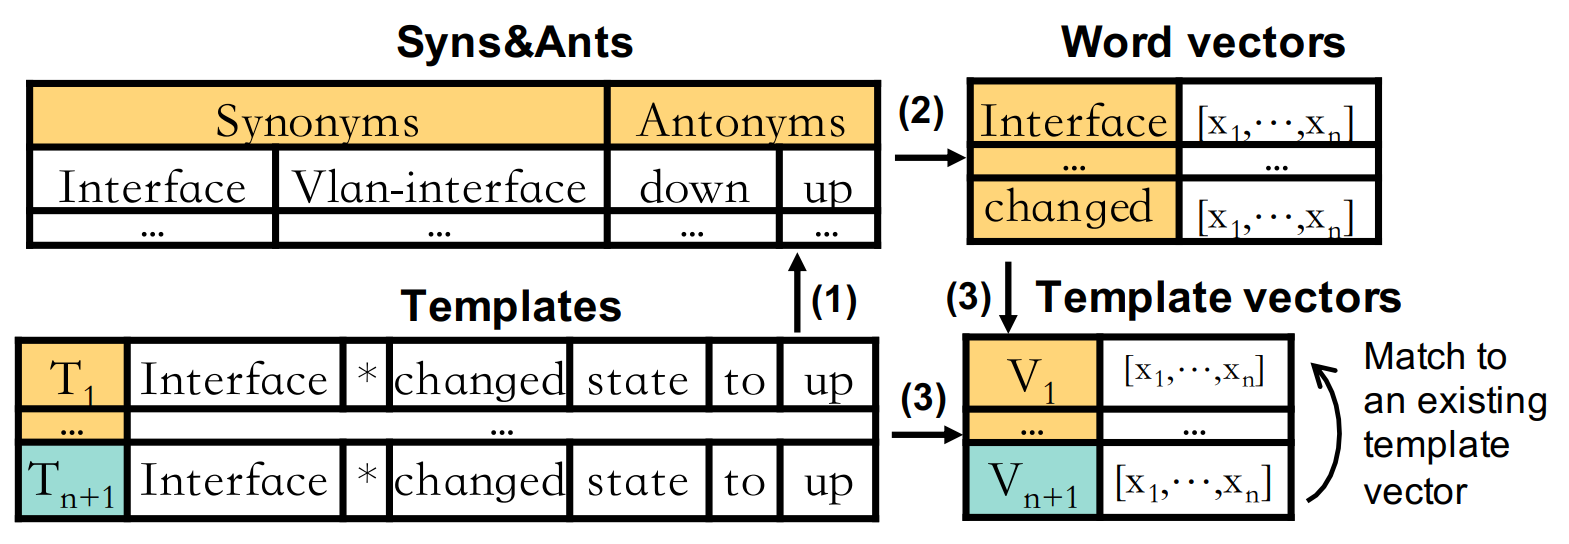

Сначала применим Word2Vec к датасету BGL. 

[Реализация Word2Vec](https://github.com/tensorflow/tensorflow/blob/r1.1/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

Немного подробнее про Word2Vec. 

**Википедия:**

  Word2vec — общее название для совокупности моделей на основе искусственных нейронных сетей, предназначенных для получения векторных представлений слов на естественном языке. Используется для анализа семантики естественных языков, основанный на дистрибутивной семантике, машинном обучении и векторном представлении слов. Программное обеспечение под названием «Word2Vec» было разработано группой исследователей Google в 2013 году. Инструменты для создания векторно-семантических моделей существовали и ранее, но Word2Vec стал первой популярной реализацией: в первую очередь из-за удобства использования, открытого исходного кода и скорости работы.

***Описание***

  Работа программы осуществляется следующим образом: word2vec принимает большой текстовый корпус в качестве входных данных и сопоставляет каждому слову вектор, выдавая координаты слов на выходе. Сначала он генерирует словарь корпуса, а затем вычисляет векторное представление слов, «обучаясь» на входных текстах. Векторное представление основывается на контекстной близости: слова, встречающиеся в тексте рядом с одинаковыми словами (а следовательно, имеющие схожий смысл), будут иметь близкие (по косинусному расстоянию) векторы. Полученные векторные представления слов могут быть использованы для обработки естественного языка и машинного обучения.

***Алгоритмы обучения***

  В word2vec реализованы два основных алгоритма обучения: CBoW (англ. Continuous Bag of Words, «непрерывный мешок со словами», англ. bag — мультимножество) и Skip-gram. CBoW — архитектура, которая предсказывает текущее слово, исходя из окружающего его контекста. Архитектура типа Skip-gram действует наоборот: она использует текущее слово, чтобы предугадывать окружающие его слова. Построение модели word2vec возможно с помощью двух данных алгоритмов. Порядок слов контекста не оказывает влияния на результат ни в одном из этих алгоритмов.

***Результаты***

  Получаемые на выходе векторные представления слов позволяют вычислять «семантическое расстояние» между словами. Так, можно находить похожие по значению слова. Обычно приводят пример с королём и королевой: король относится к мужчине также, как королева к женщине. Word2vec выполняет прогнозирование на основании контекстной близости этих слов. Так как инструмент word2vec основан на обучении простой нейронной сети, чтобы добиться его наиболее эффективной работы, необходимо использовать большие корпусы для его обучения. Это позволяет повысить качество предсказаний.

Инициализации модели:

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences = common_texts, size = 100, window = 5, min_count = 1, workers = 4)
model.save("word2vec.model")

Можно сохранить модель, чтобы тренирровать ее позже:

In [ ]:
model = Word2Vec.load("word2vec.model")
model.train([["hello", "world"]], total_examples = 1, epochs = 1)
(0, 2)

(0, 2)

Как получить векторы слов?
Нужно обучить полную модель, затем создать массив model.wv, который содержит векторы с ключами. Например, используя алгоритм Word2Vec для обучения векторов:

In [ ]:
model = Word2Vec(lee_corpus_list, vector_size=24, epochs=100)
word_vectors = model.wv

Обученные векторы слов хранятся в отдельном модуле в виде model.wv:

In [ ]:
vector = model.wv['computer']  # получение вектора слов
sims = model.wv.most_similar('computer', topn = 10)  # получение остальных (в данном случае десяти) похожих по контексту слов

Пример: 

Есть уже заранее загруженый в модель датасет, на котором можно проверить работу модели 

In [ ]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys())) # все доступные источники датасета

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-25')
glove_vectors.most_similar('twitter') # все слова, похожие по контексту слову "twitter"

[==================================================] 100.0% 104.8/104.8MB downloaded


[('facebook', 0.9480051398277283),
 ('tweet', 0.9403422474861145),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104823470115662),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885936141014099),
 ('tweets', 0.8878157734870911),
 ('tl', 0.8778461813926697),
 ('link', 0.877821147441864),
 ('internet', 0.8753897547721863)]

Ближайшие задачи: 

1. Проверить работу алгоритма Word2Vec на датасетах BGL и HDFS из статьи
2. Написать функцию для поиска синонимов и антонимов в словаре WordNet и добавления их вручную
3. Проверить алгоритм на произвольных датасетах логов